In [1]:
import json
import os
import pandas as pd
import networkx as nx

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter


%matplotlib inline

In [2]:
cwd = os.getcwd()

rel_path = "sample_graphs/sourcecred_sourcecred.json"
abs_file_path = os.path.abspath(os.path.join(cwd, '..', rel_path))

with open(abs_file_path) as json_file:  
    data = json.load(json_file)

In [3]:
len(data[1]["nodes"])

5932

In [4]:
def jsonToMultiDiGraph(json):
    [compat, data] = json
    assert compat["type"] == "sourcecred/graph"
    assert compat["version"] == "0.4.0"
    
    def propertyDict(address):
        # Note: This code "happens to work" for the sourcecred/git and sourcecred/github
        # plugins. However, it is not a requirement that e.g. the third element of the address
        # is a type, so this code should not be used in production or with general user-provided
        # plugins
        plugin = address[1]
        type = address[2]
        return {"address": tuple(address), "plugin": plugin, "type": type}

    
    nodes = data["nodes"]
    edges = data["edges"]
    g = nx.MultiDiGraph()
    for (i, n) in enumerate(nodes):
        g.add_node(i, **propertyDict(n))
    for e in edges:
        g.add_edge(e["srcIndex"], e["dstIndex"], **propertyDict(e["address"]))
    return g

In [5]:
G = jsonToMultiDiGraph(data)

I think it would make sense to try to structure the data in one of these formats. What you have alread isn't that far from the first one in the link below.

https://networkx.github.io/documentation/stable/reference/readwrite/json_graph.html

the fact is we'll probably want to be doing both graph generators and graph analysis with networkX 

https://networkx.github.io/documentation/stable/_downloads/networkx_reference.pdf

so it would make it a lot smoother to move between reality and R&D if the data formats matched.

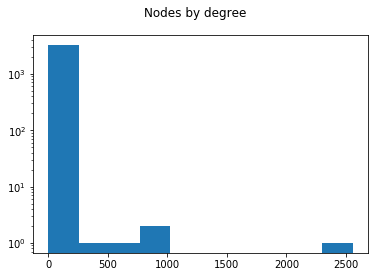

In [6]:
def nodeDegreeHistogram():
    h = nx.degree_histogram(G)
    plt.hist(h)
    plt.yscale('log')
    plt.suptitle("Nodes by degree")
    plt.show()
nodeDegreeHistogram()

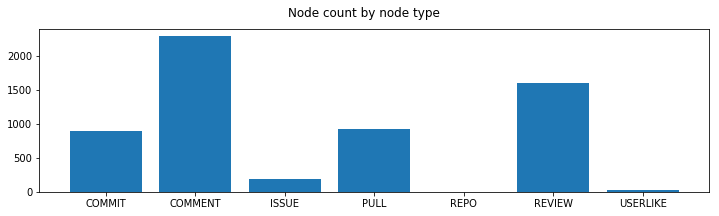

In [7]:
def nodeCountBarChart():
    node_count = Counter()
    for n in G.nodes(data=True):
        node_count[n[1]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(node_count.keys(), node_count.values())
    fig.suptitle('Node count by node type')
    plt.show()
nodeCountBarChart()

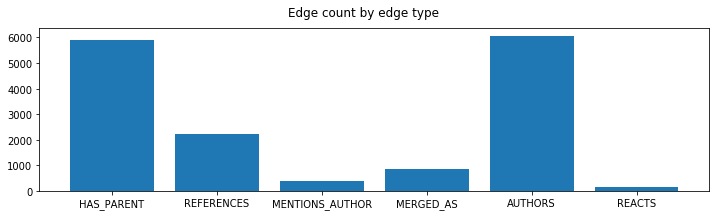

In [8]:
def edgeCountBarChart():
    edge_count = Counter()
    for e in G.edges(data=True):
        edge_count[e[2]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(edge_count.keys(), edge_count.values())
    fig.suptitle('Edge count by edge type')
    plt.show()
    
edgeCountBarChart()

In [9]:
len(G.edges(data=True))

15588

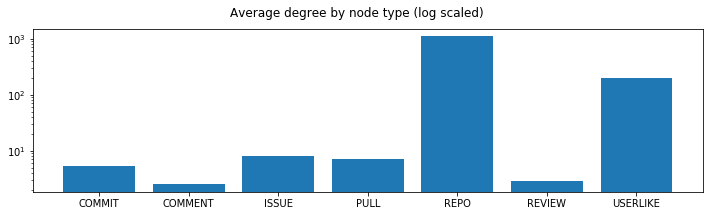

In [10]:
def nodeDegreeByTypeChart():
    type_count = Counter()
    node_type_degree = Counter()
    for n in G.nodes(data=True):
        type = n[1]["type"]
        type_count[type] += 1
        node_type_degree[type] += G.degree(n[0])
    
    average_degree = {}
    for type in type_count.keys():
        average_degree[type] = node_type_degree[type] / type_count[type]
    
    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(average_degree.keys(), average_degree.values())
    ax.set_yscale("log")
    fig.suptitle('Average degree by node type (log scaled)')
    plt.show()
nodeDegreeByTypeChart()

In [11]:
#drawing here is pretty lame without more attention to layout but you solve for you own positions
#this is a hybrid of random and circular because the simple algs were trivially useless
#and the complex algorithms couldn't compute in reasonable time

deg = dict(nx.degree(G))
N = len(G.nodes)



r1 = 1
t1 = 10
r2 = 400
t2 = 20
r3 = 1000

def get_pos(r, n, rv=True):
    if rv:
        rvx = np.random.rand()
        rvy = np.random.rand()
    else:
        rvx = 1
        rvy = 1
    
    return np.array([r*rvx*np.cos(2*np.pi*n/N) , r*rvy*np.sin(2*np.pi*n/N) ])

pos = {}
for n in G.nodes:
    if deg[n]<t1:
        pos[n] = get_pos(r1, n)
    elif deg[n]<t2:
        pos[n] = get_pos(r2, n)
    else :
        pos[n] = get_pos(r3, n)

#squelched to save runtime but not deleting,
#still referencing the above while working on plotting
#nx.draw(G, pos)

Nothing particularly interesting until we get the Graph objects "G" correctly labeled with all the meta data so we can use the more fun features of networkX.

Ongoing work below

In [12]:
#this is stored in a relatively intuitive way
#though I see some redundancy between the top level field
#I assuming we'll put anything we need for analysis as a top level field

G.nodes(data=True)[0]

{'address': ('sourcecred',
  'git',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30'),
 'plugin': 'git',
 'type': 'COMMIT'}

In [13]:
#inspection helper function
def getNodeAttributeUniques(g, attr):
    print(type(attr))
    return set(nx.get_node_attributes(g,attr).values())

In [14]:
node_types = set(nx.get_node_attributes(G,'type').values())
node_sources = set(nx.get_node_attributes(G,'plugin').values())

print(node_types)
cmap = plt.cm.jet
Nc = cmap.N
Nt = len(node_types)
dN = int(Nc/Nt)
cmaplist = [cmap(i*dN) for i in range(Nt)]

{'USERLIKE', 'REPO', 'COMMIT', 'COMMENT', 'REVIEW', 'ISSUE', 'PULL'}


In [15]:
getNodeAttributeUniques(G, 'plugin')

<class 'str'>


{'git', 'github'}

In [16]:
for k in ['plugin', 'type']:
    print(k)
    print(getNodeAttributeUniques(G, k))

plugin
<class 'str'>
{'github', 'git'}
type
<class 'str'>
{'USERLIKE', 'REPO', 'COMMIT', 'COMMENT', 'REVIEW', 'ISSUE', 'PULL'}


In [17]:
#fair warning
#this is not a very efficient implementaiton
#took a few passes to get it working

colors = {}
bunches = {}

counter = 0
for nt in node_types:
    bunches[nt] = [x for x,y in G.nodes(data=True) if y['type']==nt]
    colors[nt]  = cmaplist[counter]
    counter = counter + 1    
    
node_color = {}
for x,y in G.nodes(data=True):
    G.nodes[x]['color'] = colors[y['type']]


markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]

node_shape = {}
shapes= {}

counter = 0
for ns in node_sources:
    bunches[ns] = [x for x,y in G.nodes(data=True) if y['plugin']==ns]
    shapes[ns]  = markers[counter]
    counter = counter+1

for x,y in G.nodes(data=True):
    G.nodes[x]['shape'] = shapes[y['plugin']]

In [18]:
G.nodes[0]

{'address': ('sourcecred',
  'git',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30'),
 'plugin': 'git',
 'type': 'COMMIT',
 'color': (0.0, 0.6294117647058823, 1.0, 1.0),
 'shape': ','}

In [19]:
G.nodes[1000]

{'address': ('sourcecred',
  'github',
  'COMMENT',
  'ISSUE',
  'sourcecred',
  'sourcecred',
  '190',
  '391216103'),
 'plugin': 'github',
 'type': 'COMMENT',
 'color': (0.2371916508538899, 1.0, 0.7305502846299811, 1.0),
 'shape': '.'}

In [20]:
nx.get_node_attributes(G, 'color')[0]

(0.0, 0.6294117647058823, 1.0, 1.0)

In [21]:
def inspectSubGraph(g, seed):
    
    nbunch = seed
    for s in seed:
        nbunch = list(g.neighbors(s))+nbunch
            
    #print(nbunch)
    sg = nx.subgraph(g,set(nbunch))
    sgc = np.array(list(nx.get_node_attributes(sg,'color').values()))
    #sgs = nx.get_node_attributes(sg,'shape')
    #print(sgc)
    #nx.draw_kamada_kawai(sg, node_color =sgc, node_shape=sgs , alpha=.5)
    nx.draw_kamada_kawai(sg, node_color =sgc, node_shape = '.',alpha=.5)

further research shows that in order to dynamically determine shape from attributes i need to plot subsets of nodes at a time. this means I am going to need to break apart the substeps in the helper function above and solve the node positions, the node colors, and the node shapes as seperate helper functions, then put them back together to get an inspectSubGraph function that really works as intended.

it will also make sense to add labels and legends to make this more interpretable

In [22]:
list(G.neighbors(4291))

[4292, 505]

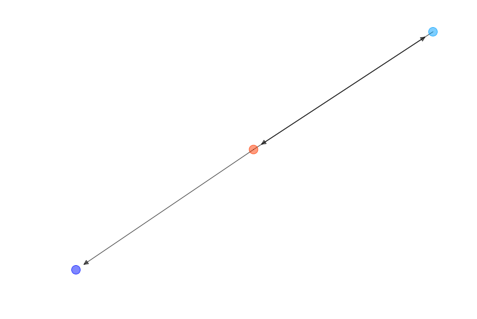

In [23]:
inspectSubGraph(G, [4291])

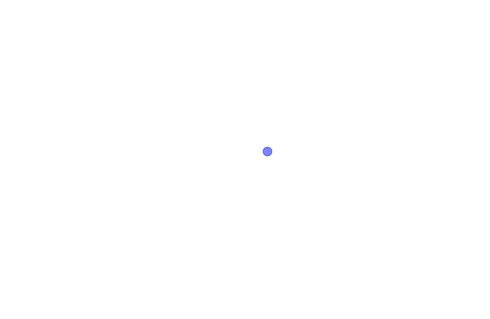

In [24]:
inspectSubGraph(G, bunches["REPO"])

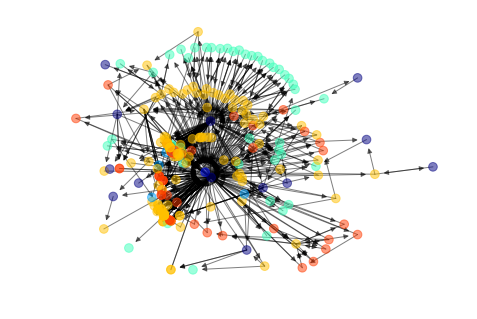

In [25]:
inspectSubGraph(G, bunches["ISSUE"])

In [26]:
#inspecting edges: this is harder to parse; the keys are tuples
nx.get_edge_attributes(G, 'address')[(0, 736, 0)]

('sourcecred',
 'git',
 'HAS_PARENT',
 '2',
 'COMMIT',
 '007cf88172d7ea9b0cdada78f124f7a41b811b30',
 '2',
 'COMMIT',
 'd310561b9473ecaa0e22da3dac089ab61df2f723')

In [27]:
nx.get_edge_attributes(G, 'type')[(0, 736, 0)]

'HAS_PARENT'

In [28]:
nx.get_edge_attributes(G, 'plugin')[(0, 736, 0)]

'git'

In [29]:
G.edges[(0, 736, 0)]

{'address': ('sourcecred',
  'git',
  'HAS_PARENT',
  '2',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30',
  '2',
  'COMMIT',
  'd310561b9473ecaa0e22da3dac089ab61df2f723'),
 'plugin': 'git',
 'type': 'HAS_PARENT'}

In [30]:
data[1]['edges'][0]

{'srcIndex': 0,
 'dstIndex': 736,
 'address': ['sourcecred',
  'git',
  'HAS_PARENT',
  '2',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30',
  '2',
  'COMMIT',
  'd310561b9473ecaa0e22da3dac089ab61df2f723']}

In [31]:
q = [k for k in G.edges.keys() if k[2]==1 ]

In [32]:
q

[(391, 121, 1),
 (648, 154, 1),
 (910, 3190, 1),
 (934, 3203, 1),
 (941, 3204, 1),
 (945, 3204, 1),
 (987, 3220, 1),
 (1035, 3243, 1),
 (1049, 3245, 1),
 (1072, 3259, 1),
 (1073, 3259, 1),
 (1085, 3262, 1),
 (1100, 3270, 1),
 (1107, 3276, 1),
 (1169, 3300, 1),
 (1180, 3306, 1),
 (1206, 3321, 1),
 (1220, 3337, 1),
 (1257, 3365, 1),
 (1264, 3365, 1),
 (1265, 3365, 1),
 (1321, 3393, 1),
 (1326, 3395, 1),
 (1344, 3405, 1),
 (1368, 3415, 1),
 (1369, 3415, 1),
 (1391, 3440, 1),
 (1393, 3440, 1),
 (1394, 3440, 1),
 (1544, 3759, 1),
 (1567, 3833, 1),
 (1609, 3933, 1),
 (1757, 4246, 1),
 (1762, 4271, 1),
 (5913, 3820, 1),
 (5913, 4238, 1),
 (5930, 3204, 1)]

Inspection above is exploring why the edge keys are 3 values not simply 2 where the values represent the source and destination nodes, as far as we can tell the third element is an index which allows us to encode successive links between the same source and destination. The relatively small number of edges with the 3rd index equals 1, indicates such duplication is rare, and in the current graph ther are no edges with third index values greater than 1.

In [33]:
print([k for k in G.edges.keys() if k[2]>1 ])

[]
